# A short overview of LightFM

## By Daniel Crha

### What is LightFM?

LightFM is a library which contains an efficient implementation of the **LightFM model**. It is suitable for both implicit and explicit feedback scenarios, and is well-optimized.

It is especially well suited for cold-start and low density scenarios. The model comes with loss functions which can optimize for precision @ k, or AUC.

It is easy to use correctly, and it works well for its intended scenario, but it's not a multi-tool. It is still just a single model which is not optimal for all scenarios.

Performance is a first-class citizen in LightFM. Model training and evaluation are able to take advantage of multi-threading just by adjusting a function parameter.

The model features some hyperparameters, which can easily be tuned using something like Scikit-Optimize.

### The LightFM model

The LightFM model is hybrid, meaning it is collaborative like matrix factorization, but also content-based.

User and item features have their own latent vectors, and the latent representation of items and users is a combination of the normal matrix factorization latent vector, as well as the content-based latent vector.

### Recommendations with MovieLens

First of all, let's try creating a model for the MovieLens dataset.
We will fit an implicit feedback model for movies with a rating of at least 3 stars.

In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

from lightfm import LightFM
from lightfm.datasets import fetch_movielens, fetch_stackexchange
from lightfm.evaluation import precision_at_k, auc_score

# Load the MovieLens 100k dataset.
# Ratings are treated as positive if the rating is at least 3.0
ml_data = fetch_movielens(min_rating=3.0)

# The k we will be using for all precision @ k measurements
k = 10

First of all, we will define a function which will train our model. It will simply iteratively train the model and every few epochs, it will evaluate how the model is doing.

In [11]:
def train_model(model, data, use_item_features=False):
    epoch_count = 100
    epoch_iters = range(10, epoch_count + 1, 10)
    patk_train = []
    patk_test = []
    auc_train = []
    auc_test = []
    item_features = data["item_features"] if use_item_features else None

    # Let's measure how long it takes to train the model as well
    print("Training model...")
    start_time = time.time()

    old_epoch = 0
    for epoch in epoch_iters:
        more = epoch - old_epoch
        model.fit_partial(
            data["train"],
            epochs=more,
            num_threads=8,
            item_features=item_features)
        old_epoch = epoch

        patk_train.append(precision_at_k(model, data["train"], k=k, item_features=item_features).mean())
        patk_test.append(precision_at_k(model, data["test"], k=k, item_features=item_features).mean())
        auc_train.append(auc_score(model, data['train'], item_features=item_features).mean())
        auc_test.append(auc_score(model, data['test'], item_features=item_features).mean())


    end_time = time.time()
    print(f"Training finished! Elapsed time: {end_time - start_time:.2f} s.")
    return epoch_iters, patk_train, patk_test, auc_train, auc_test

Now let's create the model and train it.

We'll use the `WARP` loss function. All we really need to know about it is that it optimizes for precision @ k, as opposed to `BPR` which optimizes for AUC.

Keep this in mind for later, when we examine the results.

In [3]:
# Instantiate and train the model
ml_model = LightFM(loss="warp")
epoch_iters, patk_train, patk_test, auc_train, auc_test = train_model(ml_model, ml_data)

Training model...
Training finished! Elapsed time: 6.39 s.


Let's check how precision @ k is looking during the course of training for both the training and test datasets.

In [4]:
# Nothing interesting here - just plotting
def plot_patk(epochs, patk, title, k):
    plt.plot(epochs, patk);
    plt.title(title, fontsize=20);
    plt.xlabel('Epochs', fontsize=24);
    plt.ylabel('Precision @ {}'.format(k), fontsize=24);
    plt.xticks(fontsize=14);
    plt.yticks(fontsize=14);

def plot_auc(epochs, auc, title):
    plt.plot(epochs, auc);
    plt.title(title, fontsize=20);
    plt.xlabel('Epochs', fontsize=24);
    plt.ylabel('AUC', fontsize=24);
    plt.xticks(fontsize=14);
    plt.yticks(fontsize=14);

def plot_training_evaluation(epoch_iters, patk_train, patk_test, auc_train, auc_test, title):
    plt.figure(figsize=(14, 8), dpi=80)
    plt.suptitle(title, fontsize=30)

    ax = plt.subplot(2, 2, 1)
    fig = ax.get_figure();
    sns.despine(fig);
    plot_patk(epoch_iters, patk_train, 'Train', k=k)

    ax = plt.subplot(2, 2, 2)
    fig = ax.get_figure();
    sns.despine(fig);
    plot_patk(epoch_iters, patk_test, 'Test', k=k)

    ax = plt.subplot(2, 2, 3)
    fig = ax.get_figure();
    sns.despine(fig);
    plot_auc(epoch_iters, auc_train, 'Train')

    ax = plt.subplot(2, 2, 4)
    fig = ax.get_figure();
    sns.despine(fig);
    plot_auc(epoch_iters, auc_test, 'Test')

    plt.tight_layout();

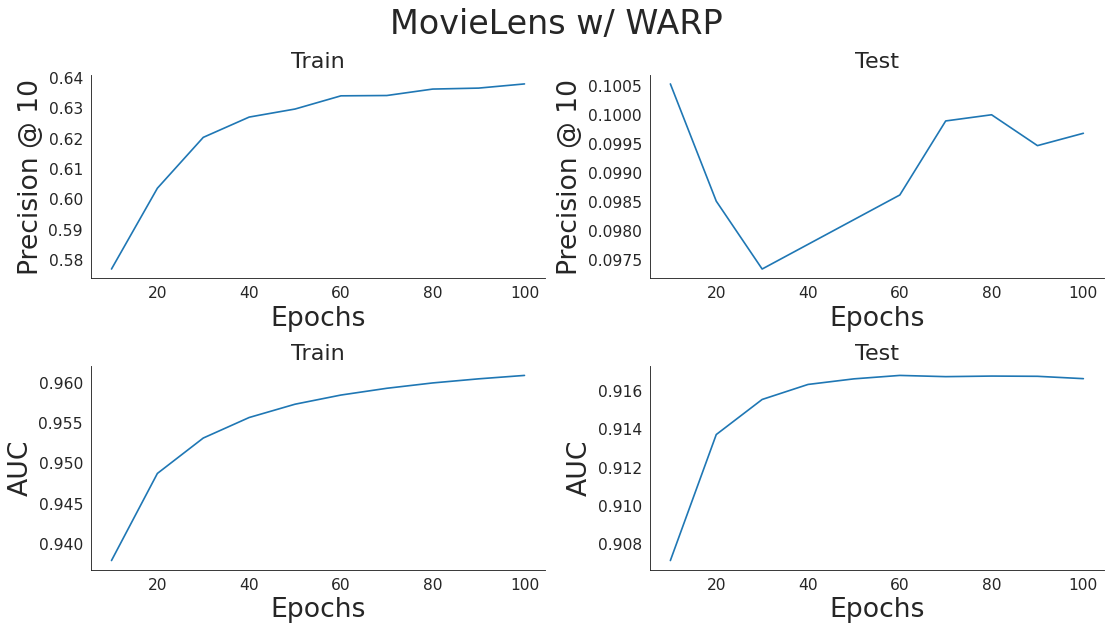

In [5]:
plot_training_evaluation(epoch_iters, patk_train, patk_test, auc_train, auc_test, "MovieLens w/ WARP")

We can see that after a while, the model starts overfitting and the test precision is declining.

As far as the speedup is concerned, I tested the effects of threading on training speed.
I evaluated the speedup on 3000 epochs.
With 16 threads, the training takes about 66 seconds.
With only 1 thread, it takes about 95 seconds.
If the dataset was larger, the speedup would probably be larger as well.

Let's also take a look at how we can make an example prediction for a single user.

In [6]:
def make_prediction_for_user(model, user_id):
    _, num_items = ml_data["train"].shape

    liked_movies = ml_data['item_labels'][ml_data['train'].tocsr()[user_id].indices]
    predicted_scores = model.predict(user_id, np.arange(num_items))
    top_items = ml_data['item_labels'][np.argsort(-predicted_scores)]
    
    # Exclude already liked items from the suggestions
    top_items = [item for item in top_items if item not in liked_movies]

    print(f"User {user_id} liked:")
    for liked_movie in liked_movies[:5]:
        print(f"    {liked_movie}")
    
    print(f"Prediction for user {user_id}:")
    for predicted_movie in top_items[:5]:
        print(f"    {predicted_movie}")

make_prediction_for_user(ml_model, 42)

User 42 liked:
    Toy Story (1995)
    Get Shorty (1995)
    Twelve Monkeys (1995)
    Babe (1995)
    Dead Man Walking (1995)
Prediction for user 42:
    Back to the Future (1985)
    Braveheart (1995)
    Much Ado About Nothing (1993)
    Emma (1996)
    Phenomenon (1996)


For comparison, we can check how it looks when we use `BPR` instead of `WARP` as the loss function.
As a reminder, `BPR` optimizes for AUC rather than precision @ k.

If we compare the results for `BPR` with `WARP`, we can clearly see how this is affecting the training.
Selecting the correct loss will depend on the needs of the user.

Training model...
Training finished! Elapsed time: 6.09 s.


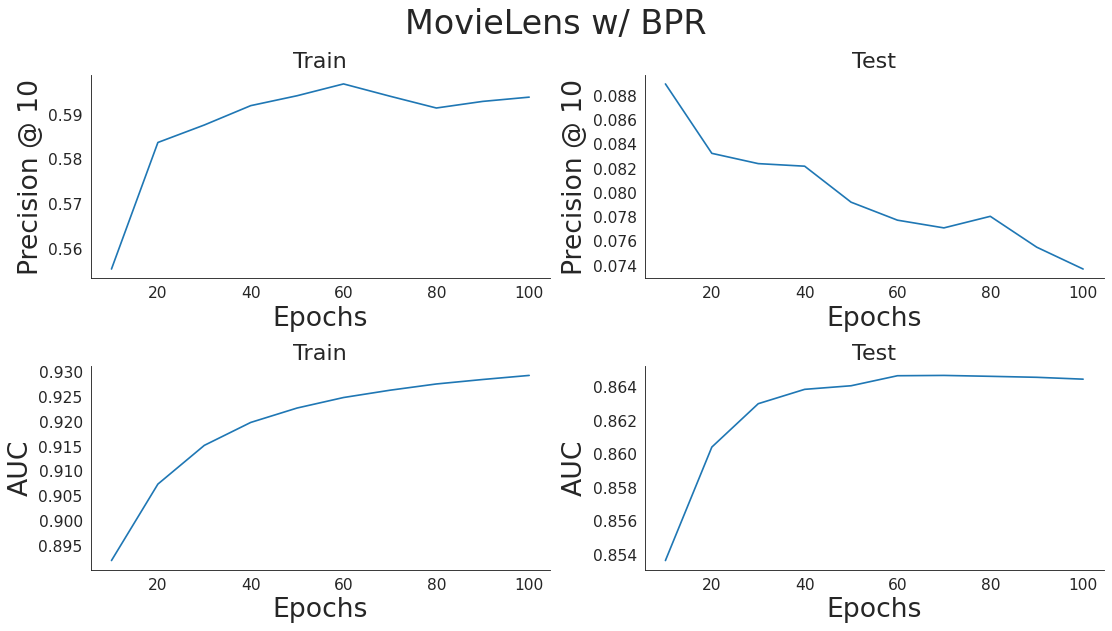

In [7]:
ml_model = LightFM(loss="bpr")
epoch_iters, patk_train, patk_test, auc_train, auc_test = train_model(ml_model, ml_data)
plot_training_evaluation(epoch_iters, patk_train, patk_test, auc_train, auc_test, "MovieLens w/ BPR")

### Recommendations with CrossValidated

This time, we will try to leverage the full capabilities of the LightFM model. We will use the CrossValidated dataset from StackExchange, where users answering questions means positive interactions. We want to try and match users with questions they might be interested in answering.

Questions are tagged with a variety of tags, which we can use for some content-based recommendations. The assumption here is that question with similar tags are likely to be answered by the same people.

First things first - let's load the CrossValidated dataset. The test set chronologically follows the training set, meaning that many questions in the test set are very new, and have no interactions. This means that we are looking at a cold-start scenario, and the content-based portion of the hybrid model will come in handy.

In [8]:
cv_data = fetch_stackexchange('crossvalidated', test_set_fraction=0.1, indicator_features=False, tag_features=True)

Before we look at the full power of the model, let's check how it looks if we *don't* use the item features. This means that we are using only the collaborative part of the model.

Training model...
Training finished! Elapsed time: 311.01 s.


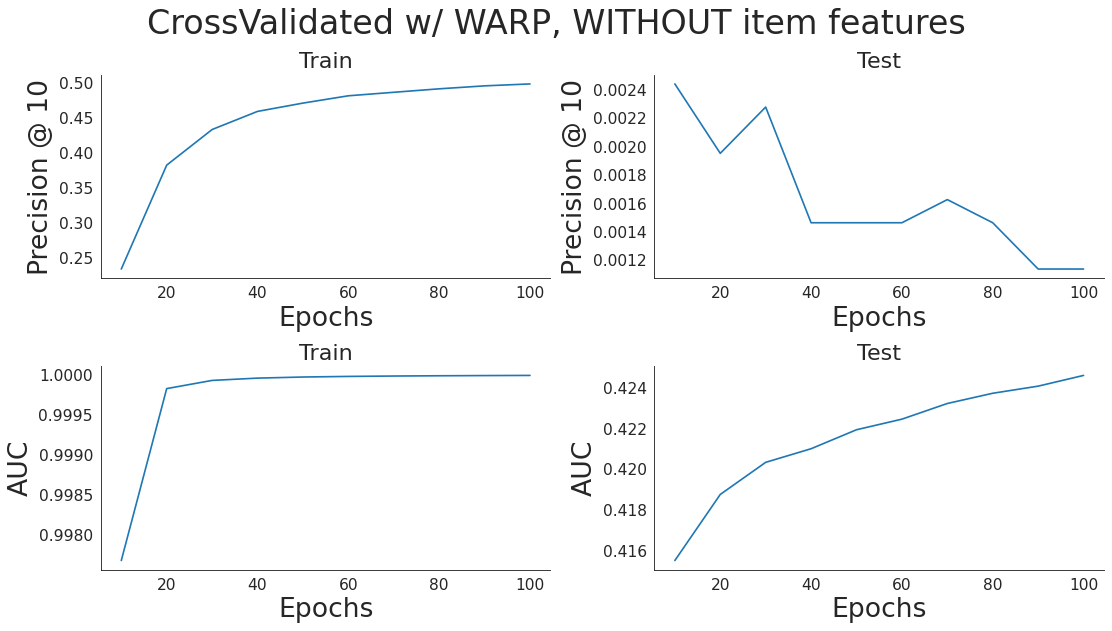

In [9]:
cv_model = LightFM(loss='warp', no_components=30, item_alpha=1e-6)
epoch_iters, patk_train, patk_test, auc_train, auc_test = train_model(cv_model, cv_data)
plot_training_evaluation(epoch_iters, patk_train, patk_test, auc_train, auc_test, "CrossValidated w/ WARP, WITHOUT item features")

We can see that the performance is very bad, as we expected. AUC being under 0.5 means we can throw this model into the bin. Since the test set questions have very little user interaction data, the collaborative-only approach is nearly useless.

Now let's take a look at what happens if we add item features!

Training model...
Training finished! Elapsed time: 455.19 s.


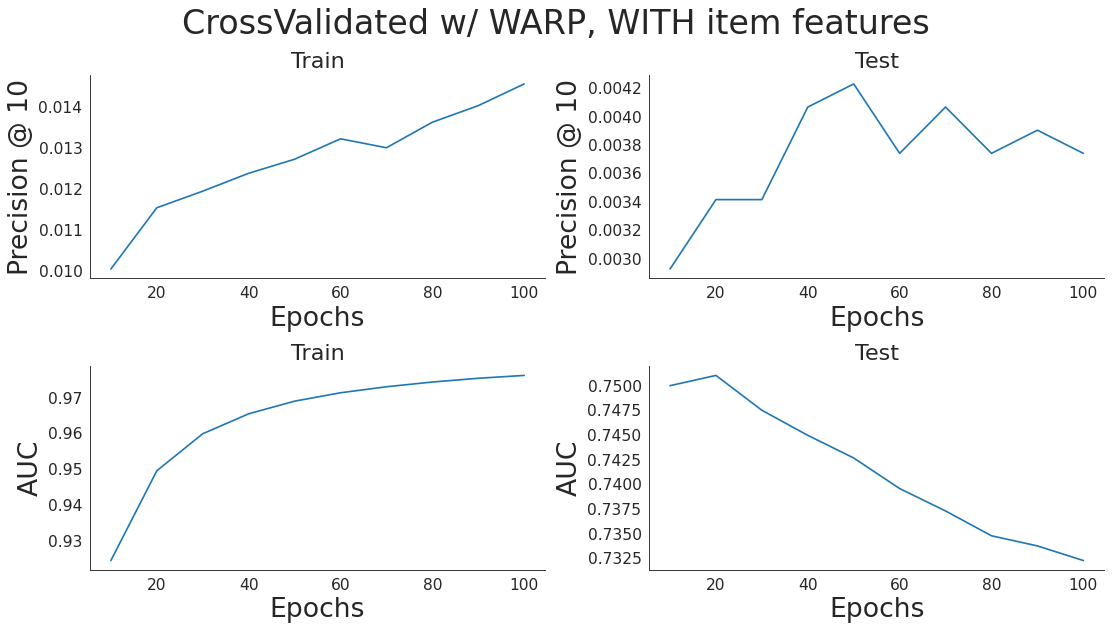

In [12]:
cv_model = LightFM(loss='warp', no_components=30, item_alpha=1e-6)
epoch_iters, patk_train, patk_test, auc_train, auc_test = train_model(cv_model, cv_data, use_item_features=True)
plot_training_evaluation(epoch_iters, patk_train, patk_test, auc_train, auc_test, "CrossValidated w/ WARP, WITH item features")

It's very obvious that this approach works much better. In a scenario where we had very little previous data, we were able to leverage content-based recommendations, even though the model is still using collaborative data when available.